In [1]:
import os
import shutil
import enjoyml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.io import imread, imsave
from skimage.transform import resize
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.decomposition import PCA
# from joblib import dump, load

# from data_engineering import read_data, get_filter_duplicates_query

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Input, Dense, Dropout, Flatten, GlobalMaxPool2D
from keras.applications.resnet_v2 import ResNet50V2
from keras.optimizers import Adam
from enjoyml.keras.layers import FixedPooling2D

In [5]:
from keras import layers, models, optimizers, callbacks, regularizers

### Загрузка данных

In [6]:
DATA_PATH = 'data/train/'
DATAFLOW_PATH = 'data/train_flow/'
enjoyml.path.make_dir_if_not_exist(DATAFLOW_PATH)
enjoyml.path.make_dir_if_not_exist(DATAFLOW_PATH + 'cat')
enjoyml.path.make_dir_if_not_exist(DATAFLOW_PATH + 'dog')

for img_name in tqdm(os.listdir(DATA_PATH)):
    label, img_number, img_format = img_name.split('.')
    new_file_path = f'{DATAFLOW_PATH + label}/{img_number}.{img_format}'
    shutil.copy(DATA_PATH + img_name, new_file_path)

0it [00:00, ?it/s]


In [7]:
# train_indixes, val_indexes = train_test_split(np.arange(work_features_matrix.shape[0]), 
#                                               test_size=0.07, stratify=work_labels, random_state=42)
# # train_indixes, val_indexes = train_test_split(np.arange(work_features_matrix.shape[0]), 
# #                                               test_size=0.50, stratify=work_labels, random_state=42)

# print(train_indixes.shape, val_indexes.shape)

# fc_model_full = get_fc_model(28)

# fc_model_full.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer='adam')
# lr_reducer = callbacks.ReduceLROnPlateau(monitor='loss', factor=5e-2, patience=3, 
#                                          min_lr=1e-15, min_delta=0.03, verbose=1)
# stopper = callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, 
#                                   verbose=1, restore_best_weights=True)

# fc_model_full.fit(work_features_matrix/255, work_labels_encoded,
#                   batch_size=256, epochs=150,
#                   callbacks=[lr_reducer, stopper])

# fc_model.fit(train_features_matrix/255, train_labels_encoded,
#              batch_size=256, epochs=150,
#              validation_data=(val_features_matrix/255, val_labels_encoded),
#              callbacks=[lr_reducer, stopper])

### Кастомная сверточная сеть, без аугментации

In [8]:
IMG_SIZE = 256#150
VALIDATION_SPLIT = 0.1
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 2
N_EPOCHS = 40

IMAGES_TOTAL_COUNT = 25000

In [9]:
def get_model():
    input_ = x = Input((IMG_SIZE, IMG_SIZE, 3))
    
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((3, 3))(x)
    
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((3, 3))(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((3, 3))(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((3, 3))(x)
    
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
#     x = MaxPool2D((3, 3))(x)
    
#     x = Flatten()(x)
    x = GlobalMaxPool2D()(x)

    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)

    return Model(inputs=input_, outputs=output)

model = get_model()
model.compile('Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 85, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 85, 85, 32)        9248      
______________________________

In [9]:
from enjoyml.multiclass import calc_class_weights
from keras.preprocessing.image import ImageDataGenerator


data_gen_args = dict(
    rescale=1/255.,
    validation_split=VALIDATION_SPLIT,
)

datagen = ImageDataGenerator(**data_gen_args)

In [10]:
lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=5e-2, patience=3, 
                                         min_lr=1e-15, min_delta=0.03, verbose=1)
stopper = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, 
                                  verbose=1, restore_best_weights=True)

In [11]:
TRAIN_STEPS_PER_EPOCH = int(IMAGES_TOTAL_COUNT * (1 - VALIDATION_SPLIT)/TRAIN_BATCH_SIZE) + 1
VAL_STEPS_PER_EPOCH = int(IMAGES_TOTAL_COUNT * VALIDATION_SPLIT/VAL_BATCH_SIZE) + 1

model.fit_generator(
    datagen.flow_from_directory(
        DATAFLOW_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=TRAIN_BATCH_SIZE,
        class_mode='binary',
        subset='training',
        shuffle=True,
    ),
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    epochs=N_EPOCHS,
#     class_weight=calc_class_weights(train_labels1),
    validation_data=datagen.flow_from_directory(
        DATAFLOW_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=VAL_BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=True,
    ),
    callbacks=[lr_reducer, stopper], 
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.

Epoch 1/40
176/176 [==============================] - 69s 393ms/step - loss: 0.6627 - accuracy: 0.5666 - val_loss: 0.3420 - val_accuracy: 0.6639
Epoch 2/40
176/176 [==============================] - 59s 333ms/step - loss: 0.5659 - accuracy: 0.6952 - val_loss: 0.7568 - val_accuracy: 0.7530
Epoch 3/40
176/176 [==============================] - 58s 331ms/step - loss: 0.4247 - accuracy: 0.7996 - val_loss: 0.1449 - val_accuracy: 0.8245
Epoch 4/40
176/176 [==============================] - 58s 327ms/step - loss: 0.3233 - accuracy: 0.8597 - val_loss: 0.1187 - val_accuracy: 0.8637
Epoch 5/40
176/176 [==============================] - 58s 327ms/step - loss: 0.2613 - accuracy: 0.8898 - val_loss: 0.0141 - val_accuracy: 0.8789
Epoch 6/40
176/176 [==============================] - 58s 328ms/step - loss: 0.2164 - accuracy: 0.9098 - val_loss: 2.9066 - val_accuracy: 0.9025
Epoch 7/40
176/176 [========================

KeyboardInterrupt: 

In [13]:
DATATEST_PATH = 'data/test/'
test_samples, test_labels = [], []

for img_name in tqdm(os.listdir(DATATEST_PATH)):
    img = imread(DATATEST_PATH + img_name)
    img = resize(img, (IMG_SIZE, IMG_SIZE))  # scales to 0..1
    sample = img_name.split('.')[0]
    label = model.predict(img[np.newaxis, :, :, :])[0][0]
    test_samples.append(sample), test_labels.append(label)

100%|██████████| 12500/12500 [03:10<00:00, 65.58it/s]


In [14]:
pd.DataFrame({'id': test_samples, 'label': test_labels}).to_csv('submission_0.csv', index=False)

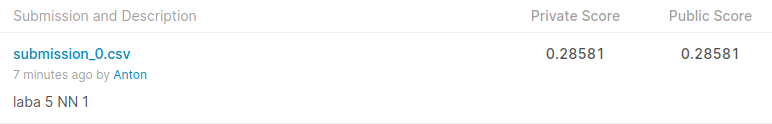

### Кастомная сверточная сеть, с аугментацией

In [8]:
IMG_SIZE = 150#150
VALIDATION_SPLIT = 0.1
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 2
N_EPOCHS = 40

IMAGES_TOTAL_COUNT = 25000

In [9]:
def get_model():
    input_ = x = Input((IMG_SIZE, IMG_SIZE, 3))
    
#     x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
#     x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
#     x = MaxPool2D((3, 3))(x)
    
#     x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
#     x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
#     x = MaxPool2D((3, 3))(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((3, 3))(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((3, 3))(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((5, 5))(x)
    
    x = Flatten()(x)
#     x = GlobalMaxPool2D()(x)

    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    return Model(inputs=input_, outputs=output)

model = get_model()
model.compile('Adam',#Adam(1e-5),#
              loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 128)       147584    
______________________________

In [10]:
from enjoyml.multiclass import calc_class_weights
from keras.preprocessing.image import ImageDataGenerator


data_gen_args = dict(
    rescale=1/255.,
    rotation_range=0.025,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.95, 1.05],
    horizontal_flip=True,
#     vertical_flip=True,
    fill_mode='reflect',
    validation_split=VALIDATION_SPLIT,
)

datagen = ImageDataGenerator(**data_gen_args)

lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=5e-2, patience=3, 
                                         min_lr=1e-15, min_delta=0.05, verbose=1)
stopper = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, 
                                  verbose=1, restore_best_weights=True)

In [11]:
TRAIN_STEPS_PER_EPOCH = int(IMAGES_TOTAL_COUNT * (1 - VALIDATION_SPLIT)/TRAIN_BATCH_SIZE) + 1
VAL_STEPS_PER_EPOCH = int(IMAGES_TOTAL_COUNT * VALIDATION_SPLIT/VAL_BATCH_SIZE) + 1

model.fit_generator(
    datagen.flow_from_directory(
        DATAFLOW_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=TRAIN_BATCH_SIZE,
        class_mode='binary',
        subset='training',
        shuffle=True,
    ),
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    epochs=N_EPOCHS,
#     class_weight=calc_class_weights(train_labels1),
    validation_data=datagen.flow_from_directory(
        DATAFLOW_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=VAL_BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=True,
    ),
    callbacks=[lr_reducer, stopper], 
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.

Epoch 1/40
176/176 [==============================] - 120s 681ms/step - loss: 0.6672 - accuracy: 0.5858 - val_loss: 0.8838 - val_accuracy: 0.6531
Epoch 2/40
176/176 [==============================] - 113s 641ms/step - loss: 0.5987 - accuracy: 0.6808 - val_loss: 0.6893 - val_accuracy: 0.7530
Epoch 3/40
176/176 [==============================] - 113s 642ms/step - loss: 0.5174 - accuracy: 0.7459 - val_loss: 0.6341 - val_accuracy: 0.7766
Epoch 4/40
176/176 [==============================] - 113s 643ms/step - loss: 0.4428 - accuracy: 0.7973 - val_loss: 0.0366 - val_accuracy: 0.8385
Epoch 5/40
176/176 [==============================] - 113s 641ms/step - loss: 0.3668 - accuracy: 0.8385 - val_loss: 0.1268 - val_accuracy: 0.8641
Epoch 6/40
176/176 [==============================] - 113s 642ms/step - loss: 0.3120 - accuracy: 0.8639 - val_loss: 1.3925 - val_accuracy: 0.8693
Epoch 7/40
176/176 [==================

KeyboardInterrupt: 

In [12]:
DATATEST_PATH = 'data/test/'
test_samples, test_labels = [], []

for img_name in tqdm(os.listdir(DATATEST_PATH)):
    img = imread(DATATEST_PATH + img_name)
    img = resize(img, (IMG_SIZE, IMG_SIZE))  # scales to 0..1
    sample = img_name.split('.')[0]
    label = model.predict(img[np.newaxis, :, :, :])[0][0]
    test_samples.append(sample), test_labels.append(label)

100%|██████████| 12500/12500 [02:49<00:00, 73.56it/s]


In [13]:
pd.DataFrame({'id': test_samples, 'label': test_labels}).to_csv('submission_1.csv', index=False)

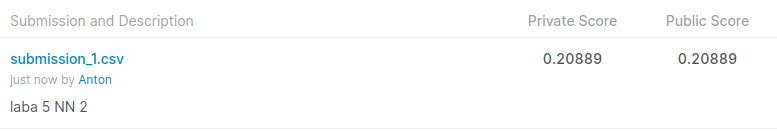

### Дообучение resnet сеть, с аугментацией

In [8]:
IMG_SIZE = 256#150
VALIDATION_SPLIT = 0.1
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 2
N_EPOCHS = 60

IMAGES_TOTAL_COUNT = 25000

In [9]:
IMAGE_NET = True

resnet_conv_base = ResNet50V2(
    include_top=False, 
    weights='imagenet' if IMAGE_NET else None, 
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)  # imagenet


def get_resnet_model():
    input_ = Input((IMG_SIZE, IMG_SIZE, 3))
    
    x = resnet_conv_base(input_)

#     x = Flatten()(x)
    x = GlobalMaxPool2D()(x)

    x = Dropout(0.4)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.35)(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.35)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_, outputs=output)
    
#     for layer in model.layers[1].layers[:-22]:
    for layer in model.layers[1].layers[:-37]:
        layer.trainable = False
    
    return model

resnet_model = get_resnet_model()
if IMAGE_NET:
    #sparse_categorical_crossentropy
    resnet_model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
else:
    resnet_model.compile('Adam', loss='binary_crossentropy', metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# resnet_conv_base.layers[:-22]

In [11]:
resnet_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50v2 (Model)           (None, 8, 8, 2048)        23564800  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               5245

In [12]:
from enjoyml.multiclass import calc_class_weights
from keras.preprocessing.image import ImageDataGenerator


data_gen_args = dict(
    rescale=1/255.,
    rotation_range=0.05,
    width_shift_range=0.125,
    height_shift_range=0.125,
    zoom_range=[0.95, 1.05],
    horizontal_flip=True,
#     vertical_flip=True,
    fill_mode='reflect',
    validation_split=VALIDATION_SPLIT,
)

datagen = ImageDataGenerator(**data_gen_args)


In [13]:
lr_reducer = callbacks.ReduceLROnPlateau(monitor='loss', factor=5e-2, patience=3, 
                                         min_lr=1e-15, min_delta=0.01, verbose=1)
stopper = callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=5, 
                                  verbose=1#, restore_best_weights=True
                                 )
stopper_val = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, 
                                  verbose=1#, restore_best_weights=True
                                     )

In [14]:
TRAIN_STEPS_PER_EPOCH = int(IMAGES_TOTAL_COUNT * (1 - VALIDATION_SPLIT)/TRAIN_BATCH_SIZE) + 1
VAL_STEPS_PER_EPOCH = int(IMAGES_TOTAL_COUNT * VALIDATION_SPLIT/VAL_BATCH_SIZE) + 1

resnet_model.fit_generator(
    datagen.flow_from_directory(
        DATAFLOW_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=TRAIN_BATCH_SIZE,
        class_mode='binary',
        subset='training',
        shuffle=True,
    ),
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    epochs=N_EPOCHS,
#     class_weight=calc_class_weights(train_labels1),
    validation_data=datagen.flow_from_directory(
        DATAFLOW_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=VAL_BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=True,
    ),
    callbacks=[lr_reducer, stopper, stopper_val], 
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.

Epoch 1/60
176/176 [==============================] - 261s 1s/step - loss: 0.9842 - accuracy: 0.8260 - val_loss: 1.7137e-10 - val_accuracy: 0.9648
Epoch 2/60
176/176 [==============================] - 246s 1s/step - loss: 0.3608 - accuracy: 0.9262 - val_loss: 5.7738e-07 - val_accuracy: 0.9716
Epoch 3/60
176/176 [==============================] - 246s 1s/step - loss: 0.2423 - accuracy: 0.9477 - val_loss: 2.9132e-04 - val_accuracy: 0.9732
Epoch 4/60
176/176 [==============================] - 246s 1s/step - loss: 0.1900 - accuracy: 0.9568 - val_loss: 4.2887e-05 - val_accuracy: 0.9780
Epoch 5/60
176/176 [==============================] - 247s 1s/step - loss: 0.1650 - accuracy: 0.9610 - val_loss: 1.1087e-08 - val_accuracy: 0.9820
Epoch 6/60
176/176 [==============================] - 246s 1s/step - loss: 0.1286 - accuracy: 0.9655 - val_loss: 1.8846e-05 - val_accuracy: 0.9792
Epoch 7/60
176/176 [============

In [14]:
resnet_model.save('resnet_model.h5')

In [36]:
from keras.models import load_model

resnet_model = load_model('resnet_model.h5')

In [15]:
DATATEST_PATH = 'data/test/'
test_samples, test_labels = [], []

for img_name in tqdm(os.listdir(DATATEST_PATH)):
    img = imread(DATATEST_PATH + img_name)
    img = resize(img, (IMG_SIZE, IMG_SIZE))  # scales to 0..1
    sample = img_name.split('.')[0]
    label = resnet_model.predict(img[np.newaxis, :, :, :])[0][0]
    test_samples.append(sample), test_labels.append(label)

100%|██████████| 12500/12500 [05:30<00:00, 37.81it/s]


In [16]:
pd.DataFrame({'id': test_samples, 'label': test_labels}).to_csv('submission.csv', index=False)

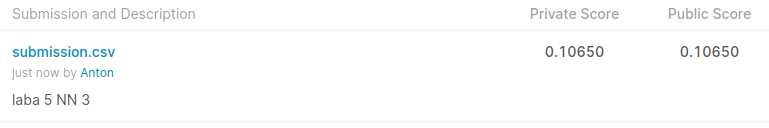

### Общее сравнение

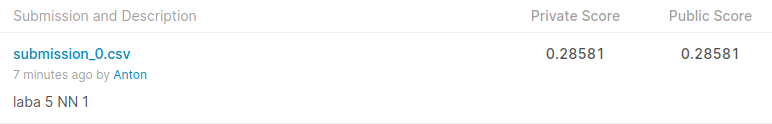

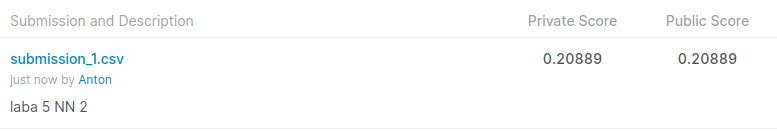

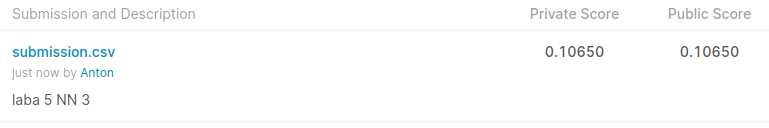